# Code by Mahdi Kallel

## Multi-task problem: colored USPS

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt

%matplotlib inline

### Colored USPS Dataset
* Handwritten digits with 10 classes
* Size of each image: 16x16 pixels 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set
* We colorize each image with a random color within 5 (red, green, blue, magenta, yellow)
* Each image has two labels: the number it represents (10 classes) and the color of the number (5 classes)

In [2]:
# Given a loaded USPS dataset, create a colozied version of it
def colorize_dataset(dataset):
    # array of colors
    COLORS = torch.tensor([
        [1.0, 0.0, 0.0], # 0 RED
        [0.0, 1.0, 0.0], # 1 GREEN
        [0.0, 0.0, 1.0], # 2 BLUE
        [1.0, 1.0, 0.0], # 3 YELLOW
        [1.0, 0.0, 1.0], # 4 MAGENTA
    ])
    N = len(dataset)
    images = torch.tensor(dataset.data/255).view(N, 1, 16, 16)
    labels = torch.tensor(dataset.targets).view(N, 1)
    color_labels = torch.randint(0, 5, (N,))
    colorized_images = images * COLORS[color_labels, :].view(N,3,1,1)
    full_labels = torch.cat((labels, color_labels.view(N, 1)), dim=1)
    return TensorDataset(colorized_images, full_labels)
    

In [3]:
# Loading MNIST dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

dataset = colorize_dataset(dataset)

In [4]:
print("The shape of the dataset is :", dataset.tensors[0].size())

The shape of the dataset is : torch.Size([7291, 3, 16, 16])


In [5]:
# split the dataset into training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

Text(0.5, 1.0, 'image label: tensor([0, 4])')

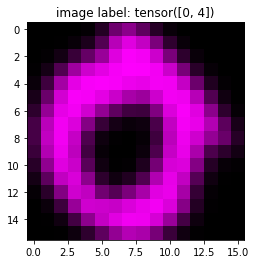

In [6]:
sample_index = 18

plt.imshow(dataset[sample_index][0].permute(1, 2, 0), plt.cm.gray_r)
plt.title("image label: {}".format(dataset[sample_index][1]))

### Training the neural network

In [120]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super (ConvBlock,self).__init__()
        self.module = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
    def forward(self,x):
        return self.module(x)

class Model(nn.Module):

    def __init__(self,n_convolutions=1,n_hidden=20,activation='relu'):

        super(Model,self).__init__()

        self.cnn= nn.Sequential()

        if activation == 'relu': self.act = nn.ReLU()
        elif activation == 'sigmoid' : self.act = nn.Sigmoid()
        elif activation == 'tanh'  : self.act = nn.Tanh()

        else: print ("NOT A FUCKING ACTIVATION")



        for i in range(n_convolutions):
            if i ==0:  self.cnn.add_module("convblock"+str(i),ConvBlock(3,5))
            else: self.cnn.add_module("convblock"+str(i),ConvBlock(5,5))
        
        self.cnn.add_module("flat",nn.Flatten(start_dim=1))
        
        self.commun = nn.Sequential(
            self.cnn,
            nn.Linear(self.cnn_out_size(),n_hidden),
            self.act,
        )
        self.color_cl = nn.Linear(n_hidden,5)
        self.class_cl = nn.Linear(n_hidden,10)
        
            
    def forward(self,x):
        
        commun_out = self.commun(x)
        out_color = F.softmax(self.color_cl(commun_out),dim=1)
        out_number = F.softmax(self.class_cl(commun_out),dim=1)

        return out_number,out_color


    def cnn_out_size(self):
        tst = torch.ones((1,3,16,16))
        return self.cnn(tst).size(-1)


m = Model(activation='relu')
m.cnn_out_size()

320

In [8]:
# define a function for training
def train(model, dataset,criterion=None,optimizer=None,num_epochs=20, batch_size=10,one_hot=True):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    
    if not optimizer: optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    if not criterion: criterion = nn.MSELoss()
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            (y_number, y_color) = model(images.float())
                
            # One-hot encoding or labels so as to calculate MSE error:
            number_onehot = F.one_hot(labels[:,0], 10).float()
            color_onehot = F.one_hot(labels[:,1], 5).float()
            
            loss = criterion(y_number, number_onehot) + criterion(y_color, color_onehot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [11]:
# Create the model: 
model = Model(n_hidden=20,n_convolutions=1)
train_error = train(model, train_set)

Epoch [1/20], Loss: 0.2505
Epoch [2/20], Loss: 0.2493
Epoch [3/20], Loss: 0.2475
Epoch [4/20], Loss: 0.2443
Epoch [5/20], Loss: 0.2385
Epoch [6/20], Loss: 0.2294
Epoch [7/20], Loss: 0.2174
Epoch [8/20], Loss: 0.2005
Epoch [9/20], Loss: 0.1735
Epoch [10/20], Loss: 0.1443
Epoch [11/20], Loss: 0.1290
Epoch [12/20], Loss: 0.1197
Epoch [13/20], Loss: 0.1114
Epoch [14/20], Loss: 0.1033
Epoch [15/20], Loss: 0.0963
Epoch [16/20], Loss: 0.0914
Epoch [17/20], Loss: 0.0881
Epoch [18/20], Loss: 0.0856
Epoch [19/20], Loss: 0.0835
Epoch [20/20], Loss: 0.0816


Text(0.5, 1.0, 'Visualization of convergence')

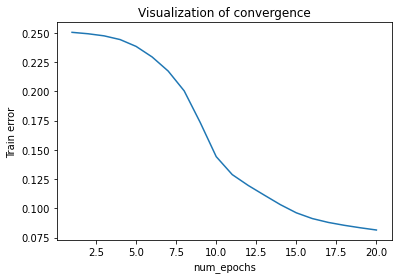

In [13]:
# plot the training error wrt. the number of epochs: 
num_epochs = 20
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the model on the validation set

In [14]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        number_correct = 0
        color_correct = 0
        both_correct = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            #images = images.view(-1, 16*16)
            (y_number, y_color) = model(images.float())
            _, number_predicted = torch.max(y_number.data, 1) 
            number_correct += (number_predicted == labels[:, 0]).sum()
            _, color_predicted = torch.max(y_color.data, 1) 
            color_correct += (color_predicted == labels[:, 1]).sum()
            both_correct += ((color_predicted == labels[:, 1]) and (number_predicted == labels[:, 0])).sum()

    print('Accuracy of the model for numbers : {:.2f} %'.format(100*number_correct.item()/ len(dataset)))
    print('Accuracy of the model for colors : {:.2f} %'.format(100*color_correct.item()/ len(dataset)))
    print('Accuracy of the model for both : {:.2f} %'.format(100*both_correct.item()/ len(dataset)))
    number_acc = 100*number_correct.item()/ len(dataset)
    color_acc  = 100*color_correct.item()/ len(dataset)
    both_acc   = 100*both_correct.item()/ len(dataset)

    return number_acc,color_acc,both_acc



In [15]:
accuracy(val_set, model)

Accuracy of the model for numbers : 29.59 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 29.59 %


(29.58946553059644, 100.0, 29.58946553059644)

Text(0.5, 1.0, 'Prediction: number=0, color=3')

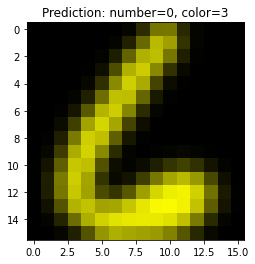

In [16]:
val_index = 66

(image, label) = val_set[val_index]
(y_number, y_color) = model(image.float().unsqueeze(0))
_, number_prediction = torch.max(y_number.data, 1)
_, color_prediction = torch.max(y_color.data, 1)

plt.imshow(image.permute(1, 2, 0), interpolation='nearest')
plt.title("Prediction: number=%d, color=%d" % (number_prediction, color_prediction))

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.
* __Your network generates two different outputs, how much weight-sharing (i.e. how many common layers) between these two paths is appropriate?__

In [23]:
trial = {'models':[],'train_errors':[],'both_acc':[]}
for i in range(3):
    model = Model(n_convolutions=i,n_hidden=20)
    train_error = train(model, train_set)
    _,_,both_acc = accuracy(val_set,model)
    trial['models'].append(model)
    trial['train_errors'].append(train_error)
    trial['both_acc'].append(both_acc)

Epoch [1/20], Loss: 0.2381
Epoch [2/20], Loss: 0.2097
Epoch [3/20], Loss: 0.1749
Epoch [4/20], Loss: 0.1417
Epoch [5/20], Loss: 0.1194
Epoch [6/20], Loss: 0.1077
Epoch [7/20], Loss: 0.1012
Epoch [8/20], Loss: 0.0973
Epoch [9/20], Loss: 0.0945
Epoch [10/20], Loss: 0.0924
Epoch [11/20], Loss: 0.0908
Epoch [12/20], Loss: 0.0893
Epoch [13/20], Loss: 0.0881
Epoch [14/20], Loss: 0.0869
Epoch [15/20], Loss: 0.0858
Epoch [16/20], Loss: 0.0847
Epoch [17/20], Loss: 0.0837
Epoch [18/20], Loss: 0.0828
Epoch [19/20], Loss: 0.0818
Epoch [20/20], Loss: 0.0809
Accuracy of the model for numbers : 33.15 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 33.15 %
Epoch [1/20], Loss: 0.2499
Epoch [2/20], Loss: 0.2469
Epoch [3/20], Loss: 0.2424
Epoch [4/20], Loss: 0.2363
Epoch [5/20], Loss: 0.2294
Epoch [6/20], Loss: 0.2209
Epoch [7/20], Loss: 0.2065
Epoch [8/20], Loss: 0.1811
Epoch [9/20], Loss: 0.1418
Epoch [10/20], Loss: 0.1096
Epoch [11/20], Loss: 0.0978
Epoch [12/20], Loss: 

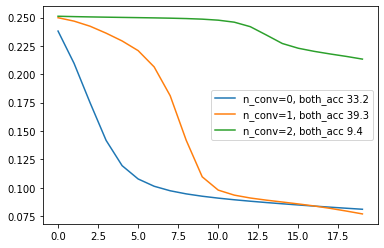

In [40]:
for i,error in enumerate(trial['train_errors']):

    both_acc = str(round(trial['both_acc'][i],1))
    plt.plot(error,label="n_conv="+str(i)+", both_acc "+both_acc)
    plt.legend()
    
plt.show()


In [51]:
trial2 = {'models':[],'train_errors':[],'both_acc':[]}
hiddens = [10,20,50,100]
for n_hidden in hiddens:
    model = Model(n_convolutions=1,n_hidden=n_hidden)
    train_error = train(model, train_set,num_epochs=20)
    _,_,both_acc = accuracy(val_set,model)
    trial2['models'].append(model)
    trial2['train_errors'].append(train_error)
    trial2['both_acc'].append(both_acc)



Epoch [1/20], Loss: 0.2510
Epoch [2/20], Loss: 0.2490
Epoch [3/20], Loss: 0.2457
Epoch [4/20], Loss: 0.2402
Epoch [5/20], Loss: 0.2327
Epoch [6/20], Loss: 0.2213
Epoch [7/20], Loss: 0.1982
Epoch [8/20], Loss: 0.1614
Epoch [9/20], Loss: 0.1292
Epoch [10/20], Loss: 0.1102
Epoch [11/20], Loss: 0.1019
Epoch [12/20], Loss: 0.0979
Epoch [13/20], Loss: 0.0953
Epoch [14/20], Loss: 0.0935
Epoch [15/20], Loss: 0.0922
Epoch [16/20], Loss: 0.0910
Epoch [17/20], Loss: 0.0900
Epoch [18/20], Loss: 0.0890
Epoch [19/20], Loss: 0.0879
Epoch [20/20], Loss: 0.0869
Accuracy of the model for numbers : 28.04 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 28.04 %
Epoch [1/20], Loss: 0.2501
Epoch [2/20], Loss: 0.2490
Epoch [3/20], Loss: 0.2475
Epoch [4/20], Loss: 0.2446
Epoch [5/20], Loss: 0.2389
Epoch [6/20], Loss: 0.2299
Epoch [7/20], Loss: 0.2203
Epoch [8/20], Loss: 0.2106
Epoch [9/20], Loss: 0.1975
Epoch [10/20], Loss: 0.1801
Epoch [11/20], Loss: 0.1645
Epoch [12/20], Loss: 

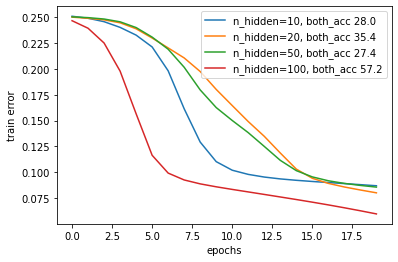

In [52]:
for i,n_hidden in enumerate(hiddens):

    both_acc = str(round(trial2['both_acc'][i],1))
    error = trial2['train_errors'][i]
    plt.plot(error,label="n_hidden="+str(n_hidden)+", both_acc "+both_acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt
    plt.legend()
    
plt.show()

In [121]:
trialx = {'models':[],'train_errors':[],'both_acc':[]}
acts = ['tanh','relu','sigmoid']
for act in acts:
    model = Model(n_convolutions=1,n_hidden=n_hidden,activation=act)
    train_error = train(model, train_set,num_epochs=20)
    _,_,both_acc = accuracy(val_set,model)
    trialx['models'].append(model)
    trialx['train_errors'].append(train_error)
    trialx['both_acc'].append(both_acc)


Epoch [1/20], Loss: 0.2481
Epoch [2/20], Loss: 0.2420
Epoch [3/20], Loss: 0.2300
Epoch [4/20], Loss: 0.2135
Epoch [5/20], Loss: 0.1917
Epoch [6/20], Loss: 0.1516
Epoch [7/20], Loss: 0.1122
Epoch [8/20], Loss: 0.0980
Epoch [9/20], Loss: 0.0928
Epoch [10/20], Loss: 0.0900
Epoch [11/20], Loss: 0.0879
Epoch [12/20], Loss: 0.0862
Epoch [13/20], Loss: 0.0845
Epoch [14/20], Loss: 0.0828
Epoch [15/20], Loss: 0.0810
Epoch [16/20], Loss: 0.0793
Epoch [17/20], Loss: 0.0775
Epoch [18/20], Loss: 0.0757
Epoch [19/20], Loss: 0.0738
Epoch [20/20], Loss: 0.0720
Accuracy of the model for numbers : 42.60 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 42.60 %
Epoch [1/20], Loss: 0.2472
Epoch [2/20], Loss: 0.2418
Epoch [3/20], Loss: 0.2311
Epoch [4/20], Loss: 0.2151
Epoch [5/20], Loss: 0.1874
Epoch [6/20], Loss: 0.1507
Epoch [7/20], Loss: 0.1239
Epoch [8/20], Loss: 0.1031
Epoch [9/20], Loss: 0.0927
Epoch [10/20], Loss: 0.0880
Epoch [11/20], Loss: 0.0848
Epoch [12/20], Loss: 

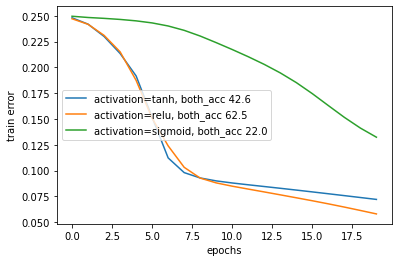

In [122]:
for i,act in enumerate(acts):

    both_acc = str(round(trialx['both_acc'][i],1))
    error = trialx['train_errors'][i]
    plt.plot(error,label="activation="+act+", both_acc "+both_acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt
    plt.legend()
    
plt.show()

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

In [55]:
trial3 = {'models':[],'train_errors':[],'both_acc':[]}
batch_sizes = [10,50,100,500,1000]
for b_size in batch_sizes:

    model = Model(n_convolutions=1,n_hidden=100)
    train_error = train(model, train_set,num_epochs=20,batch_size=b_size)
    _,_,both_acc = accuracy(val_set,model)
    trial3['models'].append(model)
    trial3['train_errors'].append(train_error)
    trial3['both_acc'].append(both_acc)

Epoch [1/20], Loss: 0.2489
Epoch [2/20], Loss: 0.2457
Epoch [3/20], Loss: 0.2384
Epoch [4/20], Loss: 0.2218
Epoch [5/20], Loss: 0.1996
Epoch [6/20], Loss: 0.1674
Epoch [7/20], Loss: 0.1263
Epoch [8/20], Loss: 0.1019
Epoch [9/20], Loss: 0.0924
Epoch [10/20], Loss: 0.0876
Epoch [11/20], Loss: 0.0841
Epoch [12/20], Loss: 0.0812
Epoch [13/20], Loss: 0.0784
Epoch [14/20], Loss: 0.0758
Epoch [15/20], Loss: 0.0732
Epoch [16/20], Loss: 0.0705
Epoch [17/20], Loss: 0.0678
Epoch [18/20], Loss: 0.0650
Epoch [19/20], Loss: 0.0620
Epoch [20/20], Loss: 0.0589
Accuracy of the model for numbers : 59.10 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 59.10 %
Epoch [1/20], Loss: 0.2497
Epoch [2/20], Loss: 0.2486
Epoch [3/20], Loss: 0.2476
Epoch [4/20], Loss: 0.2465
Epoch [5/20], Loss: 0.2453
Epoch [6/20], Loss: 0.2440
Epoch [7/20], Loss: 0.2426
Epoch [8/20], Loss: 0.2411
Epoch [9/20], Loss: 0.2394
Epoch [10/20], Loss: 0.2377
Epoch [11/20], Loss: 0.2359
Epoch [12/20], Loss: 

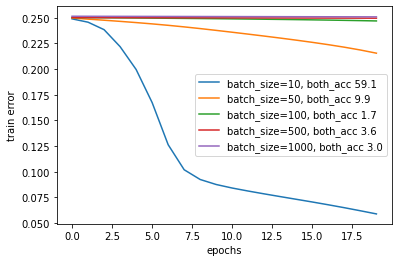

In [57]:
for i,b_size in enumerate(batch_sizes):

    both_acc = str(round(trial3['both_acc'][i],1))
    error = trial3['train_errors'][i]
    plt.plot(error,label="batch_size="+str(b_size)+", both_acc "+both_acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt
    plt.legend()
    
plt.show()

In [64]:
trial4 = {'models':[],'train_errors':[],'both_acc':[]}
lr_rates = [1e-4,1e-3,1e-2,1e-1,1,10]

for lr in lr_rates:

    model = Model(n_convolutions=1,n_hidden=100)
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    train_error = train(model, train_set,num_epochs=20,batch_size=10,optimizer=optim)
    _,_,both_acc = accuracy(val_set,model)
    trial4['models'].append(model)
    trial4['train_errors'].append(train_error)
    trial4['both_acc'].append(both_acc)

Epoch [1/20], Loss: 0.2501
Epoch [2/20], Loss: 0.2501
Epoch [3/20], Loss: 0.2501
Epoch [4/20], Loss: 0.2500
Epoch [5/20], Loss: 0.2500
Epoch [6/20], Loss: 0.2500
Epoch [7/20], Loss: 0.2500
Epoch [8/20], Loss: 0.2499
Epoch [9/20], Loss: 0.2499
Epoch [10/20], Loss: 0.2499
Epoch [11/20], Loss: 0.2499
Epoch [12/20], Loss: 0.2498
Epoch [13/20], Loss: 0.2498
Epoch [14/20], Loss: 0.2498
Epoch [15/20], Loss: 0.2497
Epoch [16/20], Loss: 0.2497
Epoch [17/20], Loss: 0.2497
Epoch [18/20], Loss: 0.2497
Epoch [19/20], Loss: 0.2496
Epoch [20/20], Loss: 0.2496
Accuracy of the model for numbers : 10.69 %
Accuracy of the model for colors : 27.11 %
Accuracy of the model for both : 2.71 %
Epoch [1/20], Loss: 0.2501
Epoch [2/20], Loss: 0.2500
Epoch [3/20], Loss: 0.2499
Epoch [4/20], Loss: 0.2498
Epoch [5/20], Loss: 0.2497
Epoch [6/20], Loss: 0.2496
Epoch [7/20], Loss: 0.2495
Epoch [8/20], Loss: 0.2494
Epoch [9/20], Loss: 0.2493
Epoch [10/20], Loss: 0.2492
Epoch [11/20], Loss: 0.2490
Epoch [12/20], Loss: 0.

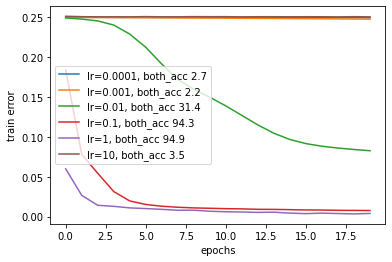

In [65]:
for i,lr in enumerate(lr_rates):

    both_acc = str(round(trial4['both_acc'][i],1))
    error = trial4['train_errors'][i]
    plt.plot(error,label="lr="+str(lr)+", both_acc "+both_acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt.legend()
    
plt.show()

In [92]:
trial6 = {'models':[],'train_errors':[],'both_acc':[]}
from torch.optim import SGD,RMSprop,Adam


opts_str = ['SGD','RMSprop','Adam']

for opt_str in opts_str:

    model = Model(n_convolutions=1,n_hidden=100)
    if opt_str == 'SGD': opt = SGD(model.parameters(),lr=0.1)
    if opt_str == 'RMSprop' : opt = RMSprop(model.parameters())
    if opt_str == 'Adam' : opt=Adam(model.parameters())
    
    train_error = train(model, train_set,num_epochs=10,batch_size=10,optimizer=opt)
    _,_,both_acc = accuracy(val_set,model)
    trial6['models'].append(model)
    trial6['train_errors'].append(train_error)
    trial6['both_acc'].append(both_acc)

Epoch [1/10], Loss: 0.1979
Epoch [2/10], Loss: 0.0784
Epoch [3/10], Loss: 0.0515
Epoch [4/10], Loss: 0.0285
Epoch [5/10], Loss: 0.0188
Epoch [6/10], Loss: 0.0151
Epoch [7/10], Loss: 0.0131
Epoch [8/10], Loss: 0.0123
Epoch [9/10], Loss: 0.0113
Epoch [10/10], Loss: 0.0107
Accuracy of the model for numbers : 91.09 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 91.09 %
Epoch [1/10], Loss: 0.1035
Epoch [2/10], Loss: 0.0419
Epoch [3/10], Loss: 0.0319
Epoch [4/10], Loss: 0.0271
Epoch [5/10], Loss: 0.0241
Epoch [6/10], Loss: 0.0221
Epoch [7/10], Loss: 0.0216
Epoch [8/10], Loss: 0.0206
Epoch [9/10], Loss: 0.0204
Epoch [10/10], Loss: 0.0187
Accuracy of the model for numbers : 85.98 %
Accuracy of the model for colors : 99.54 %
Accuracy of the model for both : 85.75 %
Epoch [1/10], Loss: 0.0633
Epoch [2/10], Loss: 0.0152
Epoch [3/10], Loss: 0.0118
Epoch [4/10], Loss: 0.0108
Epoch [5/10], Loss: 0.0095
Epoch [6/10], Loss: 0.0090
Epoch [7/10], Loss: 0.0079
Epoch [8/10]

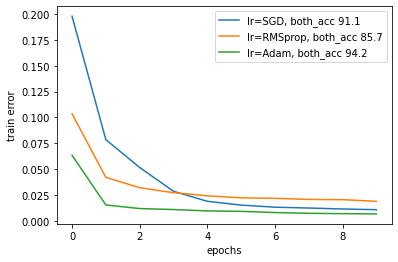

In [94]:
for i,opt in enumerate(opts_str):

    both_acc = str(round(trial6['both_acc'][i],1))
    error = trial6['train_errors'][i]
    plt.plot(error,label="lr="+opt+", both_acc "+both_acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt.legend()
    
plt.show()

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

In [103]:
class ModelCE(nn.Module):

    def __init__(self,n_convolutions=1,n_hidden=20):

        super(ModelCE,self).__init__()

        self.cnn= nn.Sequential()


        for i in range(n_convolutions):
            if i ==0:  self.cnn.add_module("convblock"+str(i),ConvBlock(3,5))
            else: self.cnn.add_module("convblock"+str(i),ConvBlock(5,5))
        
        self.cnn.add_module("flat",nn.Flatten(start_dim=1))
        
        self.commun = nn.Sequential(
            self.cnn,
            nn.Linear(self.cnn_out_size(),n_hidden),
            nn.ReLU()
        )
        self.color_cl = nn.Linear(n_hidden,5)
        self.class_cl = nn.Linear(n_hidden,10)
        
            
    def forward(self,x):
        
        commun_out = self.commun(x)
        out_color = self.color_cl(commun_out)
        out_number = self.class_cl(commun_out)

        return out_number,out_color


    def cnn_out_size(self):
        tst = torch.ones((1,3,16,16))
        return self.cnn(tst).size(-1)



# define a function for training
def TrainCE(model, dataset,criterion=None,optimizer=None,num_epochs=20, batch_size=10,one_hot=True):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    
    if not optimizer: optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    if not criterion: criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            (y_number, y_color) = model(images.float())
            
           
                
            # One-hot encoding or labels so as to calculate MSE error:
            #number_onehot = torch.Tensor(labels[:,0]).float()
            #color_onehot  = torch.Tensor(labels[:,1]).float()
            number_onehot = labels[:,0]
            color_onehot  = labels[:,1]
    
            loss = criterion(y_number, number_onehot) + criterion(y_color, color_onehot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error




Epoch [1/20], Loss: 2.5359
Epoch [2/20], Loss: 0.5449
Epoch [3/20], Loss: 0.3445
Epoch [4/20], Loss: 0.2991
Epoch [5/20], Loss: 0.2727
Epoch [6/20], Loss: 0.2505
Epoch [7/20], Loss: 0.2333
Epoch [8/20], Loss: 0.2158
Epoch [9/20], Loss: 0.2026
Epoch [10/20], Loss: 0.1882
Epoch [11/20], Loss: 0.1790
Epoch [12/20], Loss: 0.1671
Epoch [13/20], Loss: 0.1558
Epoch [14/20], Loss: 0.1454
Epoch [15/20], Loss: 0.1400
Epoch [16/20], Loss: 0.1316
Epoch [17/20], Loss: 0.1304
Epoch [18/20], Loss: 0.1161
Epoch [19/20], Loss: 0.1128
Epoch [20/20], Loss: 0.1045


[2.5359330911437654,
 0.5449211564039188,
 0.3445040466822687,
 0.29911133879485224,
 0.2727413886288805,
 0.25046076525080346,
 0.23332048860068114,
 0.2157512893159096,
 0.20261704261802735,
 0.18821864085892864,
 0.17903851980032998,
 0.16710581560910207,
 0.15581863286478134,
 0.14536515715667828,
 0.13999054270835273,
 0.1316056178647945,
 0.13038459960720494,
 0.11605057032584831,
 0.112800784917005,
 0.10449363744400521]

In [106]:
trial7 = {'models':[],'train_errors':[],'both_acc':[]}
from torch.optim import SGD,RMSprop,Adam


opts_str = ['SGD','RMSprop','Adam']

for opt_str in opts_str:

    model = ModelCE(n_convolutions=1,n_hidden=100)
    if opt_str == 'SGD': opt = SGD(model.parameters(),lr=0.1)
    if opt_str == 'RMSprop' : opt = RMSprop(model.parameters())
    if opt_str == 'Adam' : opt=Adam(model.parameters())
    
    train_error = TrainCE(model, train_set,num_epochs=10,batch_size=10,optimizer=opt)
    _,_,both_acc = accuracy(val_set,model)
    trial7['models'].append(model)
    trial7['train_errors'].append(train_error)
    trial7['both_acc'].append(both_acc)

Epoch [1/10], Loss: 0.9128
Epoch [2/10], Loss: 0.3042
Epoch [3/10], Loss: 0.2198
Epoch [4/10], Loss: 0.1829
Epoch [5/10], Loss: 0.1572
Epoch [6/10], Loss: 0.1359
Epoch [7/10], Loss: 0.1136
Epoch [8/10], Loss: 0.0903
Epoch [9/10], Loss: 0.0779
Epoch [10/10], Loss: 0.0742
Accuracy of the model for numbers : 92.80 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 92.80 %
Epoch [1/10], Loss: 1.0093
Epoch [2/10], Loss: 0.3618
Epoch [3/10], Loss: 0.2999
Epoch [4/10], Loss: 0.2639
Epoch [5/10], Loss: 0.2268
Epoch [6/10], Loss: 0.2048
Epoch [7/10], Loss: 0.1918
Epoch [8/10], Loss: 0.1804
Epoch [9/10], Loss: 0.1700
Epoch [10/10], Loss: 0.1571
Accuracy of the model for numbers : 93.73 %
Accuracy of the model for colors : 99.54 %
Accuracy of the model for both : 93.26 %
Epoch [1/10], Loss: 1.0197
Epoch [2/10], Loss: 0.3160
Epoch [3/10], Loss: 0.2560
Epoch [4/10], Loss: 0.2305
Epoch [5/10], Loss: 0.2042
Epoch [6/10], Loss: 0.1748
Epoch [7/10], Loss: 0.1576
Epoch [8/10]

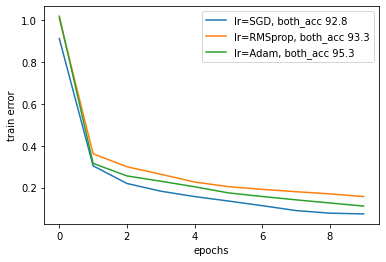

In [107]:
for i,opt in enumerate(opts_str):

    both_acc = str(round(trial7['both_acc'][i],1))
    error = trial7['train_errors'][i]
    plt.plot(error,label="lr="+opt+", both_acc "+both_acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt.legend()
    
plt.show()

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [109]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=True)
test_set = colorize_dataset(test_set)

0it [00:00, ?it/s]Downloading https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2 to USPS/usps.t.bz2
1835008it [00:06, 266485.01it/s]                             


In [113]:
accuracy(test_set, trial7['models'][2])

Accuracy of the model for numbers : 92.68 %
Accuracy of the model for colors : 100.00 %
Accuracy of the model for both : 92.68 %


(92.67563527653213, 100.0, 92.67563527653213)